## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings("ignore")
# Cross validation
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Scaling and power transformation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# Data Imbalance Handling
from imblearn import over_sampling
# Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Exploratory data analysis

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#observe the different feature type present in the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Comment:**

- In the dataset there are 284807 rows of data and 30 features.
- All the features and target variable are numeric.
- No missing value in the dataset.
- Features (V1, v2,..., v28) are obtained through PCA, hence it is not required to check for collinearity.

Here we will observe the distribution of our classes

In [6]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100
print("Percentage of Non-fradulent transaction = ", round(normal_share,3), "%")
print("Percentage of Fradulent transaction = ", round(fraud_share,3), "%")

Percentage of Non-fradulent transaction =  99.827 %
Percentage of Fradulent transaction =  0.173 %


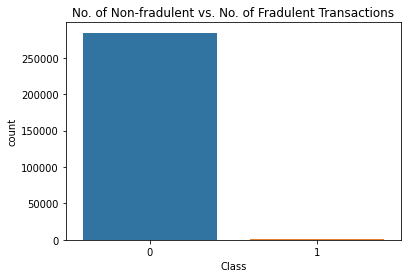

In [7]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
# Bar plot for no. of fraud and no. of non-fraudulent transcations
sns.countplot(x='Class', data=df) 
plt.title("No. of Non-fradulent vs. No. of Fradulent Transactions")
plt.show()

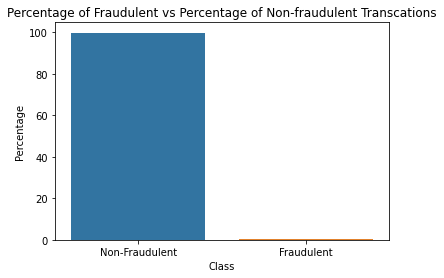

In [8]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
# Bar plot for percentage of fraud and percentage of non-fraudulent transcations
fraud_percentage = pd.DataFrame({'Class':['Non-Fraudulent', 'Fraudulent'], 'Percentage':[normal_share, fraud_share]}) 
sns.barplot(x='Class',y='Percentage', data=fraud_percentage)
plt.title('Percentage of Fraudulent vs Percentage of Non-fraudulent Transcations')
plt.show()

**Comment:**

- Number and percentage of Fradulent transactions are very less in comparision to non-fradulent transactions.
- This dataset is highly imbalanced.

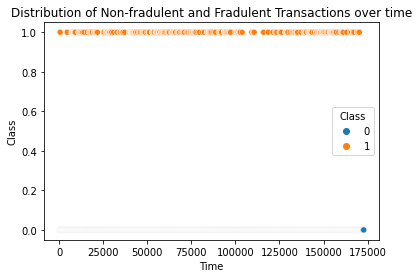

In [9]:
# Create a scatter plot to observe the distribution of classes with time

sns.scatterplot(x='Time', y='Class',hue="Class", data=df)
plt.title("Distribution of Non-fradulent and Fradulent Transactions over time")
plt.show()

**Comment:**
- There is no specific trend in Time for fradulent and non-fradulent transactions.

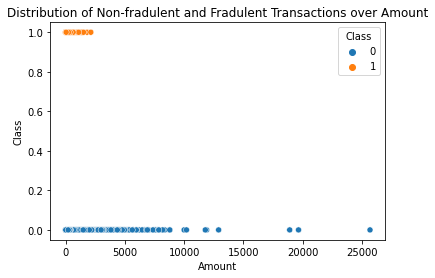

In [10]:
# Create a scatter plot to observe the distribution of classes with Amount

sns.scatterplot(x='Amount', y='Class',hue='Class',data=df)
plt.title("Distribution of Non-fradulent and Fradulent Transactions over Amount")
plt.show()

**Comment:**

- Fradulent transactions are more likely to have small "Amount" than Non-fradulent transactions.

In [11]:
# Drop unnecessary columns

# No specific pattern wrt for Fradulent and Non-fradulent transactions over time, hence dropping the feature
df.drop('Time', axis=1, inplace=True) 

### Splitting the data into train & test data

In [12]:
y = df['Class']
X = df.drop('Class', axis=1)

In [13]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=101)

# To ensure uniform distribution of fraud cases among training and test data, stratify parameter is used.

### Preserve X_test & y_test to evaluate on the test data once you build the model

In [14]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


## Feature Scaling

- Feature Scaling has to be performed before applying PCA.
- Since V1, V2,..., V28 features are obtained from PCA, Feature scaling is skipped for those.
- Feature Scaling is applied only to 'Amount'.

In [15]:
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])

### Plotting the distribution of a variable

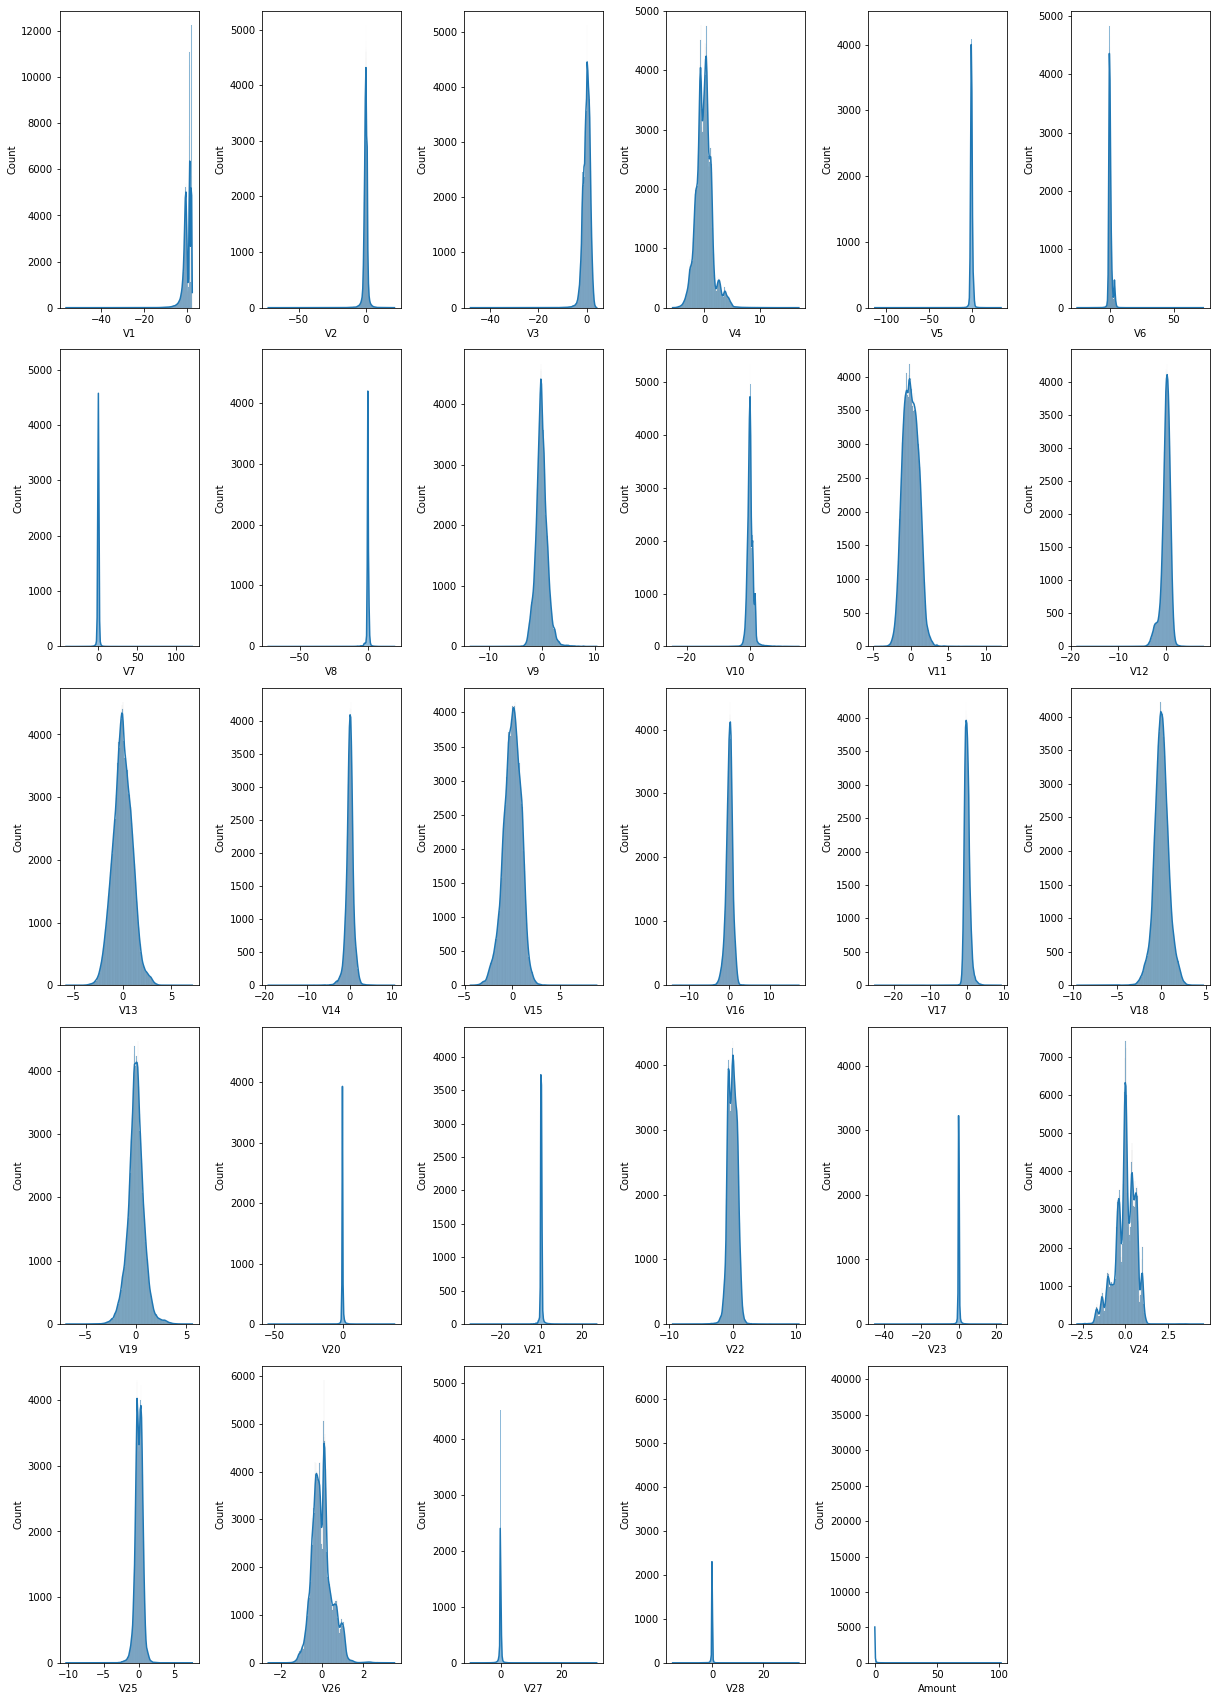

In [16]:
# plot the histogram of a variable from the dataset to see the skewness

plt.figure(figsize=(17,28))
for i, col in enumerate(X_train.columns):
  plt.subplot(6, 6, i+1)    
  sns.histplot(X_train[col], kde=True)
  plt.tight_layout()

**Comment:**
- Skewness is present in most of the features.

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [17]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data

pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
X_train.loc[:,:] = pt.fit_transform(X_train)
X_test.loc[:,:] = pt.transform(X_test)

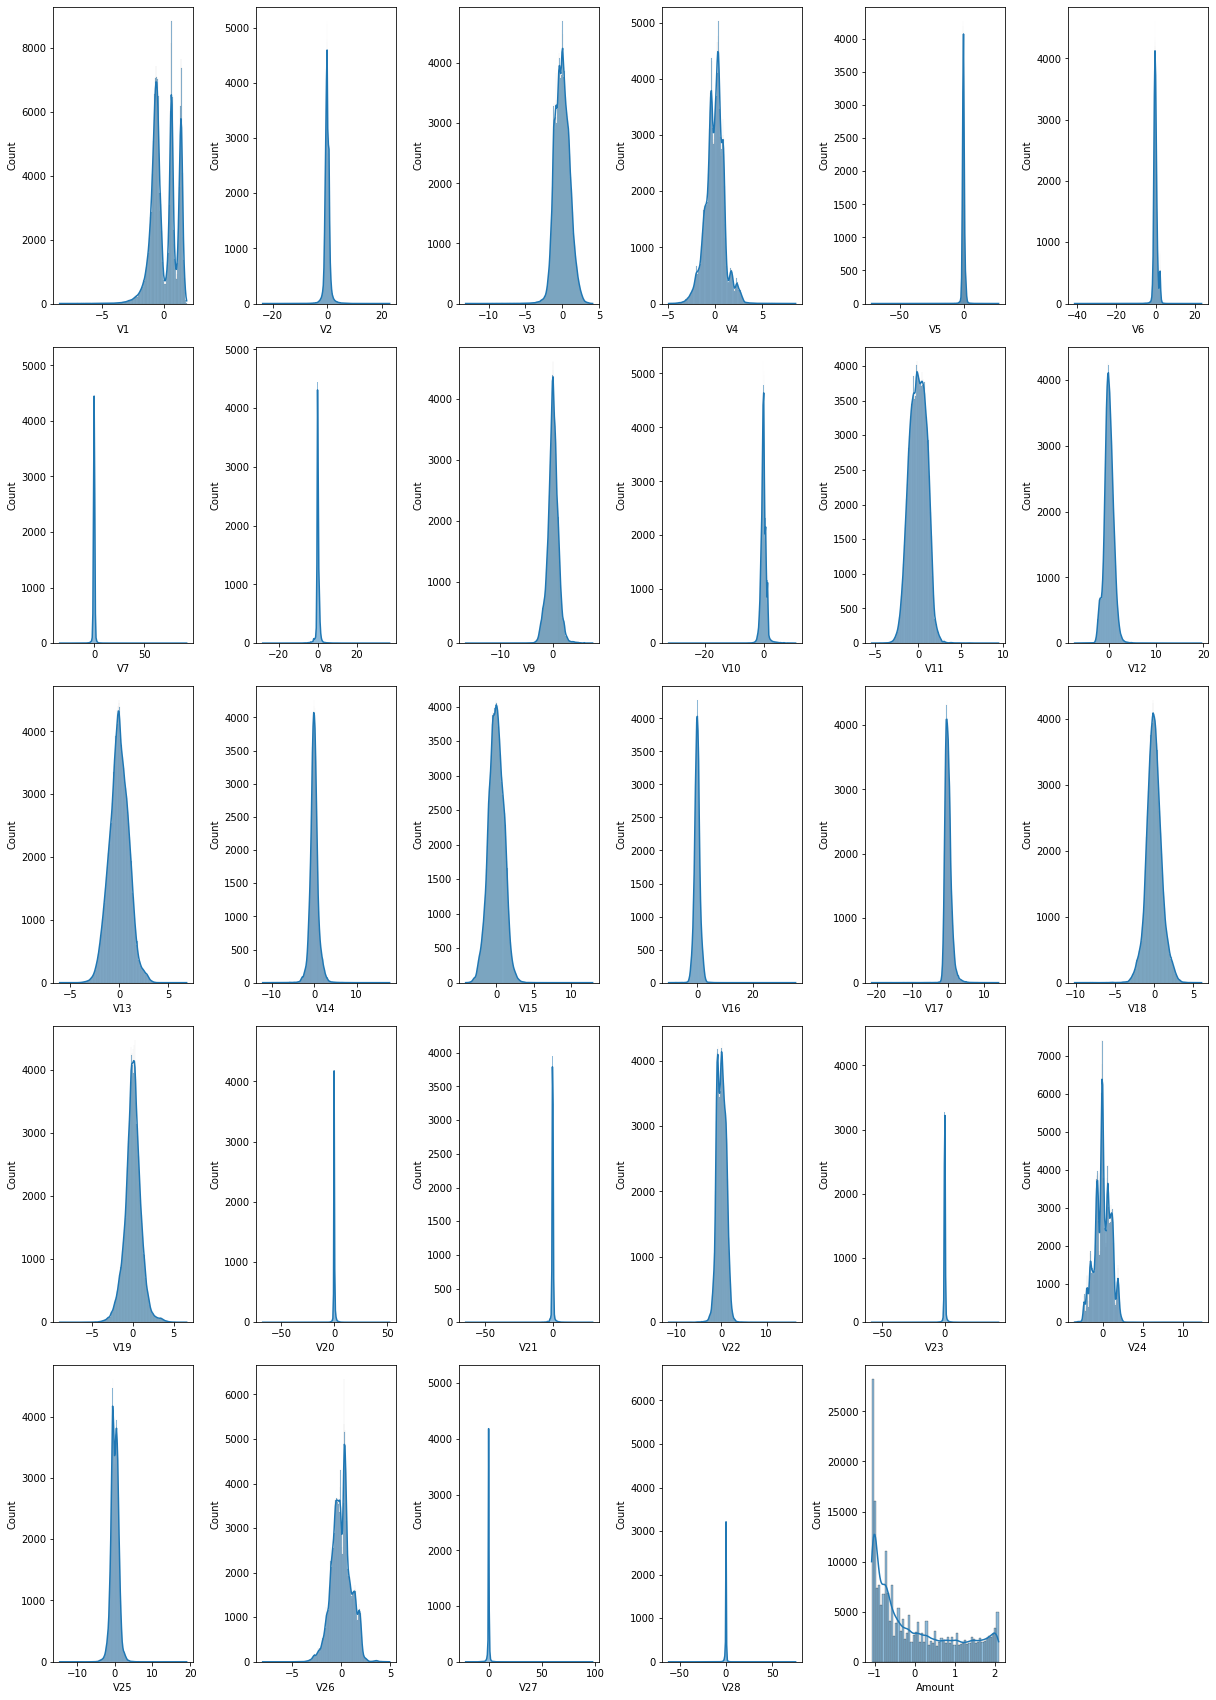

In [18]:
# plot the histogram of a variable from the dataset again to see the result 

plt.figure(figsize=(17,28))
for i, col in enumerate(X_train.columns):
  plt.subplot(6, 6, i+1)    
  sns.histplot(X_train[col], kde=True)
  plt.tight_layout()

**Comment:**

- After power transformation of the features, skewness is reduced in the distribution.

## Model Building
- Build different models on the imbalanced dataset and see the result

In [19]:
# Reusable Code block for Model Building and Evaluation

def build_model_with_cv(estimator, param_grid, cv, X_train, y_train, X_test, scoring='roc_auc'):
    model_cv = GridSearchCV(estimator = estimator,
                            param_grid = param_grid, 
                            scoring= scoring, 
                            cv = cv, 
                            verbose = 1,
                            return_train_score=True)
    # Fit the model
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    
    best_model = model_cv.best_estimator_
    best_score = model_cv.best_score_
    best_params = model_cv.best_params_
    print("Best parameters obtained by cross validation : ", best_params)

    best_model.fit(X_train, y_train)
    y_test_pred = best_model.predict(X_test)

    return y_test_pred, best_score, cv_results

eval_df = pd.DataFrame(columns=["Model Name", "Accuracy Score", "Sensitivity Score", "F1 Score", "ROC-AUC Score"])

def evaluate_model(y_true, y_pred, eval_df, roc_auc_sc, model_name="Not specified"):
    confusion = metrics.confusion_matrix(y_true, y_pred)
    TP = confusion[1,1] 
    TN = confusion[0,0] 
    FP = confusion[0,1] 
    FN = confusion[1,0] 

    accuracy_sc = metrics.accuracy_score(y_true, y_pred)
    sensitivity_score = TP / float(TP+FN)
    print("Classification Report : \n", classification_report(y_true, y_pred))

    eval_df = eval_df.append({"Model Name":model_name,
                              "Accuracy Score":accuracy_sc,
                              "Sensitivity Score":sensitivity_score,
                              "F1 Score":f1_score(y_true, y_pred),
                              "ROC-AUC Score":roc_auc_sc}, ignore_index=True)
    return eval_df

In [20]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = [0.01, 0.1, 1, 10, 100, 1000]  #--> list of values
cv_num = []  #--> list of values

# For each split, will store mean ROC_AUC_score in cv_num list

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [21]:
#perform cross validation
X_train_cv, X_test_cv, y_train_cv, y_test_cv = model_selection.train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=101)
print(X_train_cv.shape)
print(X_test_cv.shape)
print(y_train_cv.shape, np.sum(y_train_cv))
print(y_test_cv.shape, np.sum(y_test_cv))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=47)

(182276, 29)
(45569, 29)
(182276,) 315
(45569,) 79


**Comment:**
- Using StratifiedKFold to ensure distribution of Fradulent cases uniformly.
- Using n_splits=3 as this would allow approx 267 fraud cases in train data and 133 fraud cases in validation data.
- Using more number of split will make number of fraud cases in validation data (y_test_cv) < 100
- Using lesser number of split will result in insufficient number of fraud cases in train data (y_train_cv).

### Logistic Regression with Imbalanced Data

- Logistic Regression Models are built with different values of 'C'.
- 'C' value for which best ROC_AUC_score was obtained is considered for final logistic regression model with imbalanced data.

In [22]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {"C": num_C}
y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(LogisticRegression(), params, folds, X_train_cv, y_train_cv, X_test_cv, scoring='roc_auc')
cross_validation_results

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   19.4s finished


Best parameters obtained by cross validation :  {'C': 0.01}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.657030,0.038129,0.038412,0.000260,0.01,{'C': 0.01},0.983729,0.972868,0.980775,0.979124,0.004585,1,0.982669,0.986225,0.986459,0.985118,0.001734
1,0.953081,0.056169,0.043919,0.007841,0.1,{'C': 0.1},0.980978,0.974741,0.976491,0.977404,0.002627,2,0.982299,0.985841,0.986945,0.985028,0.001982
2,1.020777,0.005784,0.041322,0.004887,1,{'C': 1},0.980224,0.974513,0.975136,0.976624,0.002558,3,0.981883,0.985320,0.986635,0.984613,0.002003
3,1.028791,0.045609,0.039721,0.002918,10,{'C': 10},0.980140,0.974456,0.974972,0.976523,0.002567,4,0.981832,0.985234,0.986589,0.984552,0.002001
4,1.054065,0.031171,0.038247,0.000187,100,{'C': 100},0.980136,0.974451,0.974952,0.976513,0.002570,5,0.981826,0.985225,0.986584,0.984545,0.002001
5,1.031156,0.030711,0.038150,0.000181,1000,{'C': 1000},0.980134,0.974452,0.974951,0.976512,0.002569,6,0.981826,0.985224,0.986584,0.984545,0.002001


Mean ROC_AUC_score for different values of C : 0    0.979124
1    0.977404
2    0.976624
3    0.976523
4    0.976513
5    0.976512
Name: mean_test_score, dtype: float64


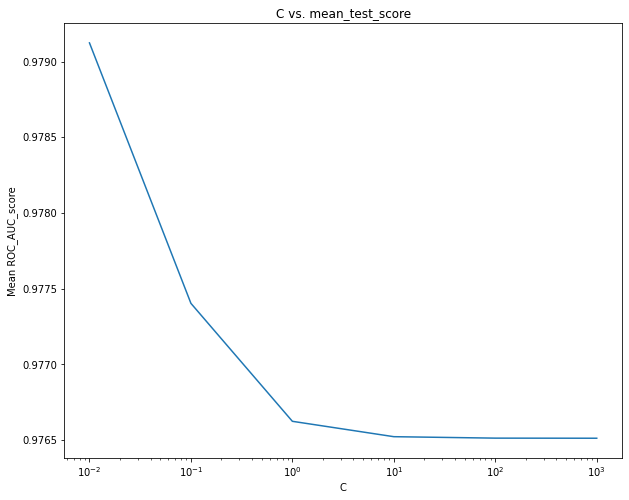

In [23]:
cv_num = cross_validation_results['mean_test_score']
print("Mean ROC_AUC_score for different values of C :", cv_num)

plt.figure(figsize=(10, 8))
plt.plot(cross_validation_results['param_C'], cross_validation_results['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Mean ROC_AUC_score')
plt.xscale('log')
plt.title('C vs. mean_test_score')
plt.show()

**Comment:**

- As observed in cross-validation with GridSearchCV and in the above figure, C=0.01 resulted in best ROC_AUC_score.

In [24]:
#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'logistic_on_imbalanced')
eval_df

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.90      0.70      0.79        79

    accuracy                           1.00     45569
   macro avg       0.95      0.85      0.89     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912


### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### KNN Classifier with Imbalanced Data

- Choosing K value for the best performance through elbow method
- Only [5, 10, 15, 25, 40] values are considered because of limited computational resources 
- Ideally model should have been trained with X_train_cv and y_train_cv like other models
- For high training time, only small sample of training data (X_test_cv, y_test_cv), cross validation and hyper parameter tuning is not done for KNN classifier for high training time.
- For final KNN model (i.e. with optimum K) complete train data (X_train, y_train) is used instead of (X_train_cv, y_train_cv).

Text(0, 0.5, 'Error Rate')

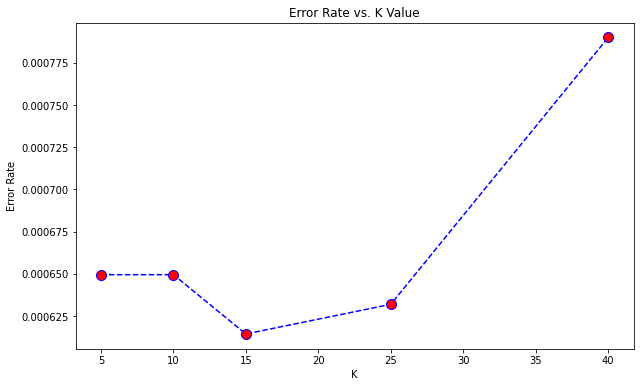

In [25]:
error_rate = []

for i in [5, 10, 15, 25, 40]:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_test_cv,y_test_cv)
    pred_i = model.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot([5, 10, 15, 25, 40],error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [26]:
# For KNN, it needs to calculate distance from one data point to the rest of the data points
# to find the nearest neighbors. This makes the training process extremely slow for large datasets
# Also we need to train several models to find optimum value of k
# Because of limitation of computation resources, cross validation is not done.

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

roc_auc_sc = round(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]), 5)
eval_df = evaluate_model(y_test, y_pred, eval_df, roc_auc_sc, model_name="KNN_on_imbalanced")
eval_df

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.78      0.84        98

    accuracy                           1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878


### SVM with Imbalanced Data

SVM algorithm is not trained with Imbalance data
- SVM Classifer does not perform well on large dataset as training time is much higher in comparision to other algorithms.
- In order to predict probability estimates [predict_proba(X) method], it uses 5 fold cross validation which slows down the training even further.

### Decision Tree with Imbalanced Data

In [27]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [20, 50, 100],
    'criterion': ["gini", "entropy"]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(DecisionTreeClassifier(random_state=101), params, folds, X_train_cv, y_train_cv, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'decision_tree_on_imbalanced')
eval_df

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  7.3min finished


Best parameters obtained by cross validation :  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.64      0.85      0.73        79

    accuracy                           1.00     45569
   macro avg       0.82      0.92      0.87     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366


### Random Forest with Imbalanced Data

In [28]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 20],
    'max_features': [3, 4, 5],
    'n_estimators': [50, 100]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(RandomForestClassifier(random_state=101, n_jobs=-1), params, folds, X_train_cv, y_train_cv, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'random_forest_on_imbalanced')
eval_df

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 30.9min finished


Best parameters obtained by cross validation :  {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.93      0.78      0.85        79

    accuracy                           1.00     45569
   macro avg       0.96      0.89      0.92     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891


### XGBoost with Imbalanced Data

In [29]:
print(type(X_train_cv))
print(type(X_test_cv))
print(type(y_train_cv))
print(type(y_test_cv))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [30]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'max_depth': [10, 20],
    'n_estimators': [100]
}

import xgboost as xgb
y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(xgb.XGBClassifier(n_jobs=-1), params, folds, X_train_cv.values, y_train_cv, X_test_cv.values, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'xgboost_on_imbalanced')
eval_df


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.2min finished


Best parameters obtained by cross validation :  {'learning_rate': 0.4, 'max_depth': 20, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.94      0.82      0.88        79

    accuracy                           1.00     45569
   macro avg       0.97      0.91      0.94     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236


#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [31]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [32]:
clf = xgb.XGBClassifier(n_jobs=-1,learning_rate=0.4,max_depth=20,n_estimators=100)  #initialise the model with optimum hyperparameters
clf.fit(X_train.values, y_train)
print("Test ROC_AUC_Score = ",round(roc_auc_score(y_test, clf.predict_proba(X_test.values)[:,1]),5)) #print --> #print the evaluation score on the X_test by choosing the best evaluation metric

Test ROC_AUC_Score =  0.98461


### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 17
2nd Top var = 14
3rd Top var = 10


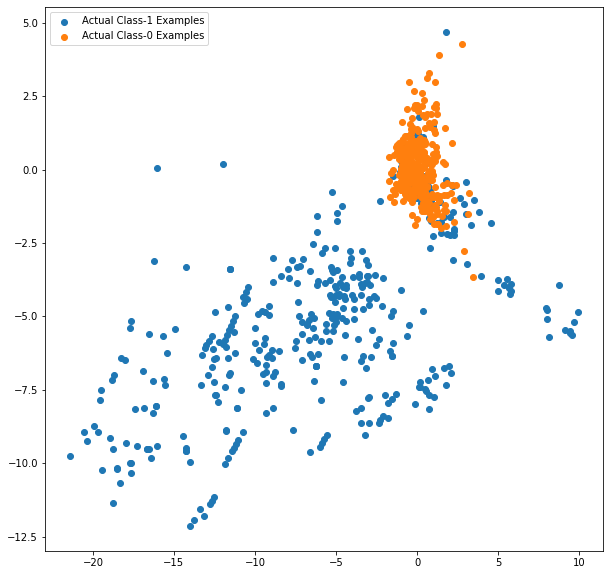

In [33]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10] # [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

In [34]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = [0.01, 0.1, 1, 10, 100, 1000]  #--> list of values
cv_num = []  #--> list of values

# For each split, will store mean ROC_AUC_score in cv_num list

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

## Random Oversampling

### Creating X_train_ros and y_train_ros

In [35]:
from imblearn import over_sampling #- import the packages

#perform cross validation & then balance classes on X_train_cv & y_train_cv using Random Oversampling
X_train_cv, X_test_cv, y_train_cv, y_test_cv = model_selection.train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=101)
X_train_ros, y_train_ros = over_sampling.RandomOverSampler(random_state=101).fit_resample(X_train_cv, y_train_cv)

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=47)

### Logistic Regression - Randomly Oversampled Data

In [36]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {"C": num_C}
y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(LogisticRegression(), params, folds, X_train_ros, y_train_ros, X_test_cv, scoring='roc_auc')
cross_validation_results

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   36.0s finished


Best parameters obtained by cross validation :  {'C': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.753586,0.070844,0.074085,0.002935,0.01,{'C': 0.01},0.988862,0.988410,0.989012,0.988761,0.000256,6,0.988708,0.988876,0.988750,0.988778,0.000071
1,1.786840,0.083565,0.071515,0.000616,0.1,{'C': 0.1},0.988974,0.988538,0.989138,0.988883,0.000253,5,0.988833,0.988992,0.988876,0.988901,0.000067
2,1.786785,0.104615,0.071019,0.001476,1,{'C': 1},0.988987,0.988548,0.989150,0.988895,0.000254,4,0.988845,0.989004,0.988887,0.988912,0.000067
3,1.780801,0.070638,0.070471,0.000877,10,{'C': 10},0.988986,0.988549,0.989150,0.988895,0.000254,3,0.988846,0.989005,0.988888,0.988913,0.000067
4,1.787549,0.054385,0.072240,0.002230,100,{'C': 100},0.988986,0.988549,0.989151,0.988895,0.000254,2,0.988846,0.989005,0.988888,0.988913,0.000067
5,1.783740,0.064297,0.070426,0.000839,1000,{'C': 1000},0.988986,0.988549,0.989151,0.988895,0.000254,1,0.988846,0.989005,0.988889,0.988913,0.000067


Mean ROC_AUC_score for different values of C : 0    0.988761
1    0.988883
2    0.988895
3    0.988895
4    0.988895
5    0.988895
Name: mean_test_score, dtype: float64


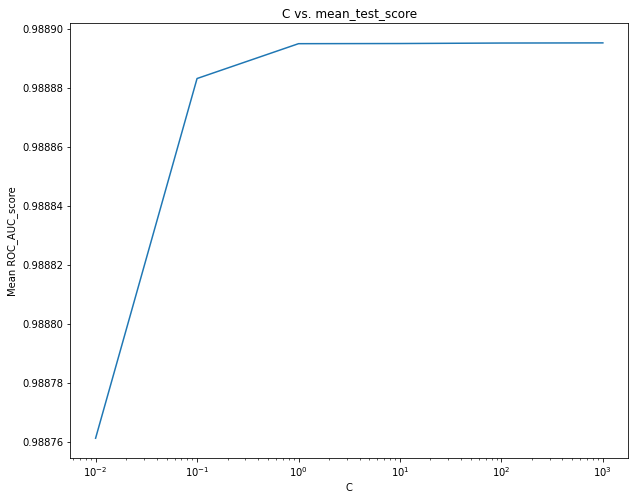

In [37]:
cv_num = cross_validation_results['mean_test_score']
print("Mean ROC_AUC_score for different values of C :", cv_num)

plt.figure(figsize=(10, 8))
plt.plot(cross_validation_results['param_C'], cross_validation_results['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Mean ROC_AUC_score')
plt.xscale('log')
plt.title('C vs. mean_test_score')
plt.show()

In [38]:
#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'logistic_on_random_oversampled')
eval_df

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     45490
           1       0.05      0.91      0.10        79

    accuracy                           0.97     45569
   macro avg       0.53      0.94      0.54     45569
weighted avg       1.00      0.97      0.98     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890


In [39]:
print("After cross validation, training data")
print(X_train_cv.shape)
print(y_train_cv.shape, np.sum(y_train_cv))
print("After Random Over sampling, training data")
print(X_train_ros.shape)
print(y_train_ros.shape, np.sum(y_train_ros))
print("Without oversampling validation data")
print(X_test_cv.shape)
print(y_test_cv.shape, np.sum(y_test_cv))
print("Without oversampling test data")
print(X_test.shape)
print(y_test.shape, np.sum(y_test))

After cross validation, training data
(182276, 29)
(182276,) 315
After Random Over sampling, training data
(363922, 29)
(363922,) 181961
Without oversampling validation data
(45569, 29)
(45569,) 79
Without oversampling test data
(56962, 29)
(56962,) 98


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### KNN with Randomly Oversampled Data

For KNN, it needs to calculate distance from one data point to the rest of the data points to find the nearest neighbors. This makes the training process extremely slow for large datasets. After oversampling the amount of training data has increased even further, which will need even higher training time.
Also we need to train several models to find optimum value of k
Because of limitation of computation resources, cross validation is not done.


In [40]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_ros, y_train_ros)
y_pred = knn.predict(X_test)

roc_auc_sc = round(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]), 5)
eval_df = evaluate_model(y_test, y_pred, eval_df, roc_auc_sc, model_name="KNN_on_random_oversampled")
eval_df

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.89      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867


### SVM with Randomly Oversampled Data

SVM algorithm is not trained with Randomly Oversampled Data
- SVM Classifer does not perform well on large dataset as training time is much higher in comparision to other algorithms.
- In order to predict probability estimates [predict_proba(X) method], it uses 5 fold cross validation which slows down the training even further.

### Decsion Tree Classifier with Ramdomly Oversampled Data

In [41]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [20, 50],
    'criterion': ["gini", "entropy"]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(DecisionTreeClassifier(random_state=101), params, folds, X_train_ros, y_train_ros, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'decision_tree_on_random_oversampled')
eval_df

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.1min finished


Best parameters obtained by cross validation :  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 20}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.53      0.84      0.65        79

    accuracy                           1.00     45569
   macro avg       0.76      0.92      0.82     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977


### Random Forest Classifier with Ramdomly Oversampled Data

In [42]:
print(type(X_train_ros))
print(type(y_train_ros))
print(type(X_test_cv))
print(type(y_test_cv))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [43]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 20],
    'max_features': [4, 5],
    'n_estimators': [100]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(RandomForestClassifier(random_state=101, n_jobs=-1), params, folds, X_train_ros, y_train_ros, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'random_forest_on_random_oversampled')
eval_df

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 21.6min finished


Best parameters obtained by cross validation :  {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 5, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.80      0.84      0.81        79

    accuracy                           1.00     45569
   macro avg       0.90      0.92      0.91     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996


### XGBoost Classifier with Ramdomly Oversampled Data

In [44]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [10, 20],
    'n_estimators': [100]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(xgb.XGBClassifier(n_jobs=-1), params, folds, X_train_ros, y_train_ros, X_test_cv.values, scoring='roc_auc')

# print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'xgboost_on_random_oversampled')
eval_df

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 14.4min finished


Best parameters obtained by cross validation :  {'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.87      0.85      0.86        79

    accuracy                           1.00     45569
   macro avg       0.93      0.92      0.93     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### Best model on Random Oversampled data

- With respect to ROC_AUC score XGBoost classifer performed best on randomly oversampled data. [ROC_AUC_score = 0.99999]
- With respect to Sensitivity score Logistic Regression performed best on randomly oversampled data. [Sensitivity = 0.911392]

## Print the class distribution after applying SMOTE 

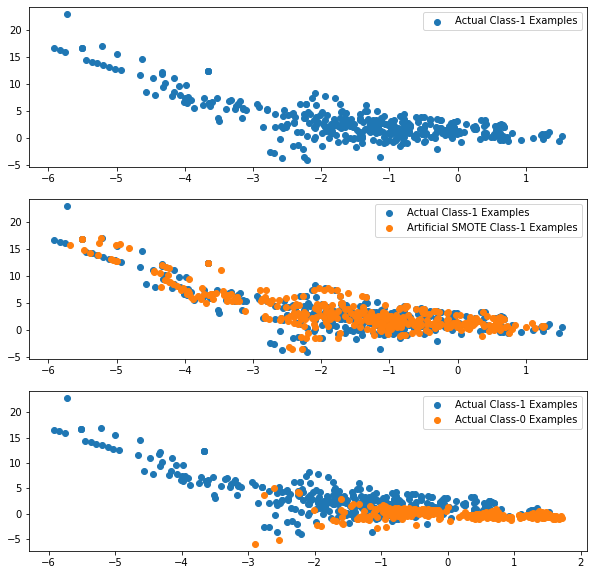

In [45]:
import warnings
warnings.filterwarnings("ignore")

sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [10, 10] #[20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Creating X_train_smote and y_train_smote

In [46]:
#perform cross validation 
X_train_cv, X_test_cv, y_train_cv, y_test_cv = model_selection.train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=101)

#then balance classes on X_train_cv & y_train_cv using SMOTE
sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train_cv, y_train_cv)

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=47)

### Logistic Regression with SMOTE

In [47]:
#perform hyperparameter tuning
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

#print the evaluation result by choosing a evaluation metric
#print the optimum value of hyperparameters
y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(LogisticRegression(), params, folds, X_train_smote, y_train_smote, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'logistic_on_smote')
eval_df

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   35.8s finished


Best parameters obtained by cross validation :  {'C': 1000}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     45490
           1       0.05      0.89      0.09        79

    accuracy                           0.97     45569
   macro avg       0.52      0.93      0.54     45569
weighted avg       1.00      0.97      0.98     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### Build models on other algorithms to see the better performing on SMOTE

### KNN with SMOTE

For KNN, it needs to calculate distance from one data point to the rest of the data points to find the nearest neighbors. This makes the training process extremely slow for large datasets. After SMOTE the amount of training data has increased even further, which will need even higher training time.
Also we need to train several models to find optimum value of k
Because of limitation of computation resources, cross validation is not done.


In [48]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_smote, y_train_smote)
y_pred = knn.predict(X_test)

roc_auc_sc = round(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]), 5)
eval_df = evaluate_model(y_test, y_pred, eval_df, roc_auc_sc, model_name="KNN_on_SMOTE")
eval_df

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.91      0.39        98

    accuracy                           1.00     56962
   macro avg       0.62      0.95      0.69     56962
weighted avg       1.00      1.00      1.00     56962



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### SVM with SMOTE

SVM algorithm is not trained with SMOTE
- SVM Classifer does not perform well on large dataset as training time is much higher in comparision to other algorithms.
- In order to predict probability estimates [predict_proba(X) method], it uses 5 fold cross validation which slows down the training even further.

### Decision Tree Classifier with SMOTE

In [49]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [5, 20, 50],
    'criterion': ["entropy"]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(DecisionTreeClassifier(random_state=101), params, folds, X_train_smote, y_train_smote, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'decision_tree_on_smote')
eval_df

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.4min finished


Best parameters obtained by cross validation :  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 50}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     45490
           1       0.16      0.85      0.26        79

    accuracy                           0.99     45569
   macro avg       0.58      0.92      0.63     45569
weighted avg       1.00      0.99      0.99     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### Random Forest Classifier with SMOTE

In [50]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 20],
    'max_features': [4, 5],
    'n_estimators': [100]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(RandomForestClassifier(random_state=101, n_jobs=-1), params, folds, X_train_smote, y_train_smote, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'random_forest_on_smote')
eval_df

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 32.3min finished


Best parameters obtained by cross validation :  {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.58      0.86      0.69        79

    accuracy                           1.00     45569
   macro avg       0.79      0.93      0.85     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


In [51]:
print(type(X_train_smote))
print(type(y_train_smote))
print(type(X_test_cv))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


**Comment:**
- Since X_test_cv is a Dataframe, X_test_cv.values has to be passed to XGBoost model, otherwise it will throw error.

### XGBoost Classifier with SMOTE

In [52]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [10, 20],
    'n_estimators': [100]
}

import xgboost as xgb
y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(xgb.XGBClassifier(n_jobs=-1), params, folds, X_train_smote, y_train_smote, X_test_cv.values, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'xgboost_on_smote')
eval_df

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 26.5min finished


Best parameters obtained by cross validation :  {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.78      0.86      0.82        79

    accuracy                           1.00     45569
   macro avg       0.89      0.93      0.91     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### Best model on SMOTE

- With respect to ROC_AUC score XGBoost classifer performed best on randomly oversampled data. [ROC_AUC_score = 0.99999]
- With respect to Sensitivity score KNN performed best on randomly oversampled data. [Sensitivity = 0.908163]

## Print the class distribution after applying ADASYN

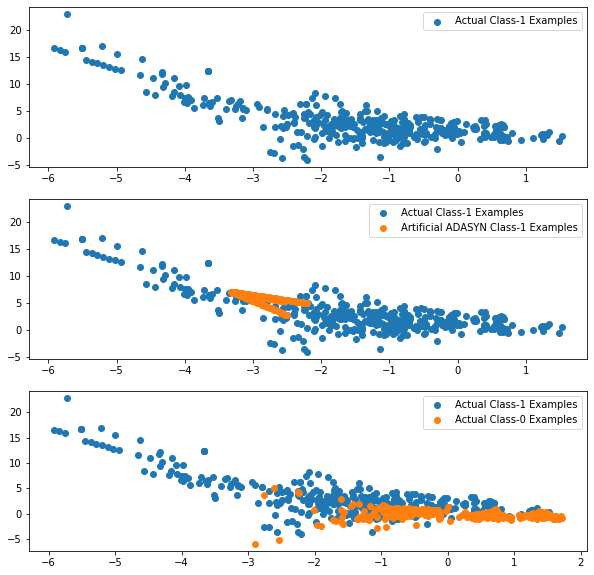

In [53]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10] # [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Creating X_train_adasyn and y_train_adasyn

In [54]:
#perform cross validation 
X_train_cv, X_test_cv, y_train_cv, y_test_cv = model_selection.train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=101)

#then balance classes on X_train_cv & y_train_cv using ADASYN
ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train_cv, y_train_cv)

### Logistic Regression with ADASYN

In [55]:
#perform hyperparameter tuning
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=47)
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

#print the evaluation result by choosing a evaluation metric
#print the optimum value of hyperparameters
y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(LogisticRegression(), params, folds, X_train_adasyn, y_train_adasyn, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'logistic_on_adasyn')
eval_df

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   33.3s finished


Best parameters obtained by cross validation :  {'C': 1000}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     45490
           1       0.02      0.92      0.03        79

    accuracy                           0.91     45569
   macro avg       0.51      0.92      0.49     45569
weighted avg       1.00      0.91      0.95     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### Build models on other algorithms to see the better performing on ADASYN

### KNN with ADASYN

For KNN, it needs to calculate distance from one data point to the rest of the data points to find the nearest neighbors. This makes the training process extremely slow for large datasets. After ADASYN the amount of training data has increased even further, which will need even higher training time.
Also we need to train several models to find optimum value of k
Because of limitation of computation resources, cross validation is not done.


In [56]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_adasyn, y_train_adasyn)
y_pred = knn.predict(X_test)

roc_auc_sc = round(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]), 5)
eval_df = evaluate_model(y_test, y_pred, eval_df, roc_auc_sc, model_name="KNN_on_ADASYN")
eval_df

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.91      0.38        98

    accuracy                           0.99     56962
   macro avg       0.62      0.95      0.69     56962
weighted avg       1.00      0.99      1.00     56962



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### SVM with ADASYN

SVM algorithm is not trained with ADASYN
- SVM Classifer does not perform well on large dataset as training time is much higher in comparision to other algorithms.
- In order to predict probability estimates [predict_proba(X) method], it uses 5 fold cross validation which slows down the training even further.

### Decision Tree Classifier with ADASYN

In [57]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [20, 50],
    'criterion': ["entropy"]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(DecisionTreeClassifier(random_state=101), params, folds, X_train_adasyn, y_train_adasyn, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'decision_tree_on_adasyn')
eval_df

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.3min finished


Best parameters obtained by cross validation :  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.23      0.85      0.37        79

    accuracy                           0.99     45569
   macro avg       0.62      0.92      0.68     45569
weighted avg       1.00      0.99      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### Random Forest Classifier with ADASYN

In [58]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 20],
    'max_features': [4, 5],
    'n_estimators': [100]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(RandomForestClassifier(random_state=101, n_jobs=-1), params, folds, X_train_adasyn, y_train_adasyn, X_test_cv, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'random_forest_on_adasyn')
eval_df

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 29.7min finished


Best parameters obtained by cross validation :  {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 5, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     45490
           1       0.16      0.86      0.26        79

    accuracy                           0.99     45569
   macro avg       0.58      0.93      0.63     45569
weighted avg       1.00      0.99      0.99     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


### XGBoost Classifier with ADASYN

In [59]:
print(type(X_train_adasyn))
print(type(y_train_adasyn))
print(type(X_test_cv))
print(type(y_test_cv))
print(type(X_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [60]:
#perform hyperparameter tuning
#print the optimum value of hyperparameters
params = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [10, 20],
    'n_estimators': [100]
}

y_test_pred, roc_auc_sc, cross_validation_results = build_model_with_cv(xgb.XGBClassifier(n_jobs=-1), params, folds, X_train_adasyn, y_train_adasyn, X_test_cv.values, scoring='roc_auc')

#print the evaluation result by choosing a evaluation metric
eval_df = evaluate_model(y_test_cv, y_test_pred, eval_df, round(roc_auc_sc,5), 'xgboost_on_adasyn')
eval_df

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 28.2min finished


Best parameters obtained by cross validation :  {'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 100}
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.78      0.85      0.81        79

    accuracy                           1.00     45569
   macro avg       0.89      0.92      0.91     45569
weighted avg       1.00      1.00      1.00     45569



,Model Name,Accuracy Score,Sensitivity Score,F1 Score,ROC-AUC Score
0,logistic_on_imbalanced,0.999342,0.696203,0.785714,0.97912
1,KNN_on_imbalanced,0.999473,0.775510,0.835165,0.94878
2,decision_tree_on_imbalanced,0.998925,0.848101,0.732240,0.95366
3,random_forest_on_imbalanced,0.999517,0.784810,0.849315,0.97891
4,xgboost_on_imbalanced,0.999605,0.822785,0.878378,0.98236
5,logistic_on_random_oversampled,0.970594,0.911392,0.097035,0.98890
6,KNN_on_random_oversampled,0.998069,0.887755,0.612676,0.94867
7,decision_tree_on_random_oversampled,0.998420,0.835443,0.647059,0.99977
8,random_forest_on_random_oversampled,0.999342,0.835443,0.814815,0.99996
9,xgboost_on_random_oversampled,0.999517,0.848101,0.858974,0.99999


## Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

Before choosing the final model we will take a close look at the models.

- Random Forest with SMOTE
- XGBoost Classifier with ADASYN and 
- XGBoost Classifier with SMOTE.

These models have very good ROC_AUC_Score and similar sensitivity score. We will inspect the precision and F1 score of class=1 i.e. Fradulent cases.


Previously for cross validation and model comparison, oversampling was performed on X_train_cv and y_train_cv, while validation data (X_test_cv, y_test_cv) and test (X_test, y_test) data was set aside. Before choosing final model, we are applying oversampling X_train and y_train. 

In [61]:
sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)



In [62]:
print("Size of original training data :")
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("Number of Fraud Transactions : ", np.sum(y_train))

print("Size of SMOTE training data :")
print("X_train_smote : ", X_train_smote.shape)
print("y_train_smote : ", y_train_smote.shape)
print("Number of Fraud Transactions : ", np.sum(y_train_smote))

print(type(X_train_smote))
print(type(y_train_smote))

print(type(X_test))
print(type(y_test))

Size of original training data :
X_train :  (227845, 29)
y_train :  (227845,)
Number of Fraud Transactions :  394
Size of SMOTE training data :
X_train_smote :  (454902, 29)
y_train_smote :  (454902,)
Number of Fraud Transactions :  227451
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [63]:
df[df['Class']==1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

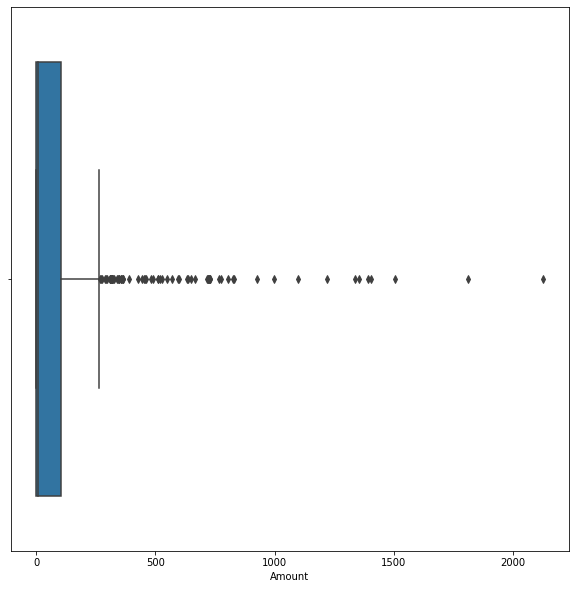

In [64]:
sns.boxplot(df[df['Class']==1]['Amount'])
plt.show()

**Comment:**

Model performance on validation data

- Random Forest Classifier with SMOTE had ROC_AUC_Score of 0.99975. Sensitivity or Recall for class=1 (fraud case) were very good as well (0.86). However precision is very poor for class=1 (0.58).

- Precision = True_positive/(True_positive + False_positive), This means out of the total predicted fraud transactions only 58% cases are truly fradulent. If Random Forest classifier is chosen, huge number of genuine transactions will be flagged as fradulent and more human effort would be required to verify transactions.

- Also, for fradulent transaction average amount is 122 unit.

- class=1 or Fradulent cases are more important than class=0 Non-fradulent cases, hence recall and precision of class=1 are mentioned.

- XGBoost Classifier with SMOTE and ADASYN had ROC_AUC_Score of 0.99999.

- XGBoost with SMOTE had recall = 0.86 and precision = 0.78 (on class=1)

- XGBoost with ADASYN had recall = 0.85 and precision = 0.78 (on class=1)

- For same precison, XGBoost with SMOTE had better recall score, this will be the final model.

Since for final model, X_train_smote and y_train_smote are generated from X_train and y_train instead of X_train_cv and y_train_cv. This will improve the performance of the model.

In [65]:
# perform the best oversampling method on X_train & y_train
clf = xgb.XGBClassifier(learning_rate=0.3,max_depth=10,n_estimators=100,n_jobs=-1)    #initialise the model with optimum hyperparameters
clf.fit(X_train_smote, y_train_smote) # fit on the balanced dataset
y_test_pred = clf.predict(X_test.values)
#--> print the evaluation score on the X_test by choosing the best evaluation metric
print("ROC_AUC_Score on test data = ",round(roc_auc_score(y_test, clf.predict_proba(X_test.values)[:, 1]),5)) 

confusion = metrics.confusion_matrix(y_test, y_test_pred)
TP,TN,FP,FN = confusion[1,1],confusion[0,0],confusion[0,1],confusion[1,0]
sensitivity_score = TP / float(TP+FN)
print("Sensitivity Score on test data = ",round(sensitivity_score,5))

ROC_AUC_Score on test data =  0.98771
Sensitivity Score on test data =  0.89796


## Selecting Best Model, oversampling method and Evaluation Metric:

- **Evalutation Metric for selecting model** : **ROC_AUC_SCORE and sensitivity score** on validation data. ROC_AUC_SCORE is chosen as it is independent of thresold. Sensitivity score = True_Positive/(True_Positive + False_Negavtive).

Here it is more important to identify the fraud transactions correctly i.e. we want to maximize True Positive Rate and minimize False Negative Rate. This means we need to find a model with maximum ROC_AUC_Score and Sensitivity score.

- **Selected Algorithm** : **XGBoost Classifier**
- **Selected oversampling method** : **SMOTE oversampling method** 
- **Hyperparameters** : learning_rate=0.3,max_depth=10,n_estimators=100

With the above combination, ROC_AUC_score of 0.98771 could be achieved on unseen data.

## Print the important features of the best model to understand the dataset

Top var = 14
2nd Top var = 4
3rd Top var = 8


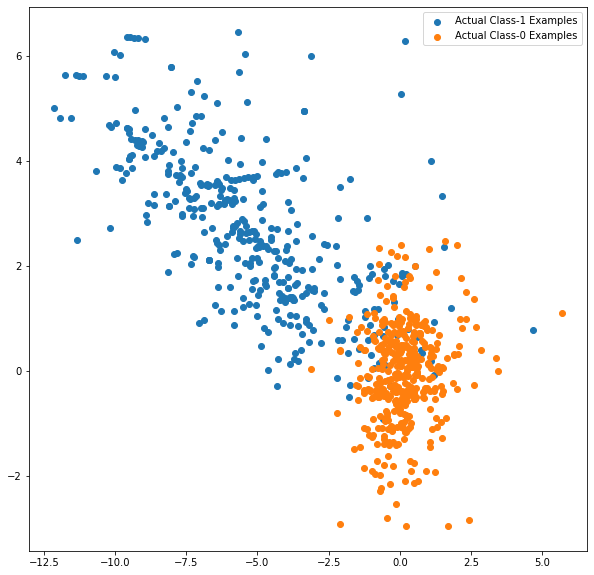

In [66]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

In [67]:
def draw_roc( true_value, prob_value ):
    fpr, tpr, thresholds = metrics.roc_curve( true_value, prob_value,
                                              drop_intermediate = False )
    roc_auc_sc = metrics.roc_auc_score( true_value, prob_value )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_sc )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None


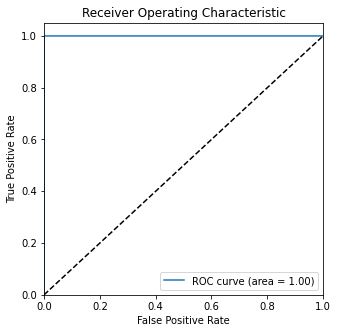

Train auc = 1.0
0.98529875


In [68]:
#### Print the FPR,TPR & select the best threshold from the roc curve
draw_roc(y_train_smote, clf.predict_proba(X_train_smote)[:, 1])

print('Train auc =', metrics.roc_auc_score(y_train_smote, clf.predict_proba(X_train_smote)[:, 1]))
fpr, tpr, thresholds = metrics.roc_curve(y_train_smote, clf.predict_proba(X_train_smote)[:, 1], drop_intermediate=False)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)

## Summary

- For limitation of computational rescources cross-validation and hyperparameter tuning are not done for KNN and SVM.

- Model performance improved after handling class imbalance. Random Forest and XGBoost Classifier performed better than Decision Tree and Logistic Regression Models.

- Since all the features are provided after PCA and feature names are not given, meaningful insight could not be drawn from them.

- **In case of banks with a smaller average transaction amount**

- A high precision score is desired as we want to label only relevant transactions as fraudulent. For every transaction that is flagged as fraudulent, an extra factor of human verification can be added. Hence banks would not want a lot of unncessary human effort or misclassified non-fraudulent transactions.

- Precision = True_positive /(True_positive + False_positive), we would like minimize False_positive (misclassifying non-fraudulent transactions as fraudulent) for optimum Precision.

- **In case of banks with a larger average transaction amount**

- Here to save banks from high-value fraudulent transactions, we need to focus on a high recall to detect actual fraudulent transactions.

- Recall = True_positive /(True_positive + False_negative), we would like minimize False_negative (misclassifying fraudulent transactions as non-fraudulent) for optimum Recall.

- Considering the above, we chose XGBoost classifier with SMOTE oversampling as the final model.

- With this we could achieve ROC_AUC_Score of 0.98771 and Sensitivity score of 0.89796, i.e. it is able to predict 90% of the fraudulent transactions.

- Optimum Hyperparameters , learning_rate=0.3,max_depth=10,n_estimators=100